# ML upskilling Barcelona Activa

## Carrega de Dades

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv ('https://raw.githubusercontent.com/ITACADEMYprojectes/projecteML/refs/heads/main/bank_dataset.CSV')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11152 non-null  float64
 1   job        11162 non-null  object 
 2   marital    11157 non-null  object 
 3   education  11155 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11162 non-null  int64  
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


## Analisi de Valors NULS

In [2]:
df.isna().sum().sort_values(ascending = False)

,0
age,10
education,7
marital,5
month,0
poutcome,0
previous,0
pdays,0
campaign,0
duration,0
contact,0


Decisions:
* Variables categoriques nul·les
    * "marital" per probabilitat seran "married"
    * "education" els incloiem en el grup de "unknown"
* Variable "age" nul·la --> moda de "age"

In [3]:
#completem els valors categorics desconeguts amb "unknown" i els buits en l'edat per la moda
df['marital'] = df["marital"].fillna("married")
df['education'] = df["education"].fillna("unknown")
df['age'] = df['age'].fillna(df['age'].mode()[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11162 non-null  float64
 1   job        11162 non-null  object 
 2   marital    11162 non-null  object 
 3   education  11162 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11162 non-null  int64  
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


## EDA

### EDA en Variables Categoriques

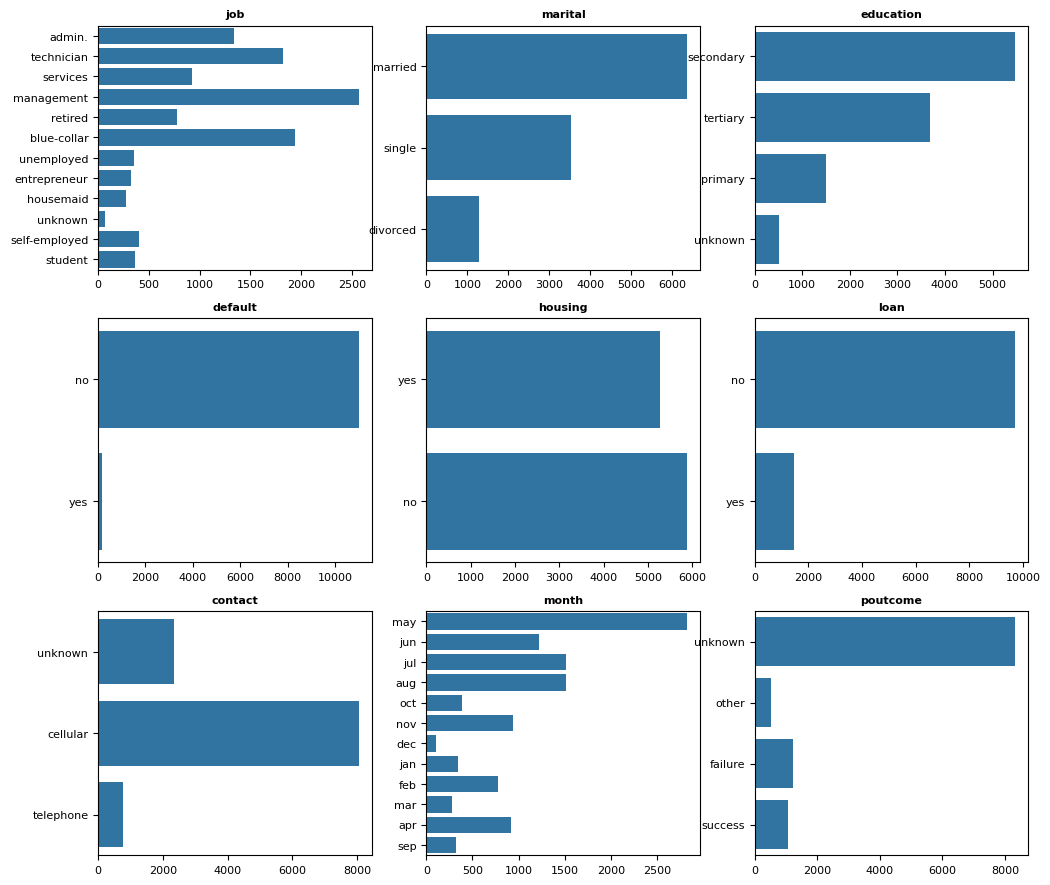

In [4]:
#check count based on categorical features
plt.figure(figsize=(12,45), facecolor='white')
plotnumber =1
categorical_features = ['job','marital','education','default','housing','loan','contact','month','poutcome']
for categorical_feature in categorical_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.countplot(y=categorical_feature,data=df)
    plt.xlabel(categorical_feature)
    plt.title(categorical_feature, fontsize = 8, fontweight = "bold")
    plt.tick_params(labelsize = 8)
    plt.xlabel("")
    plt.ylabel("")
    plotnumber+=1
plt.show()

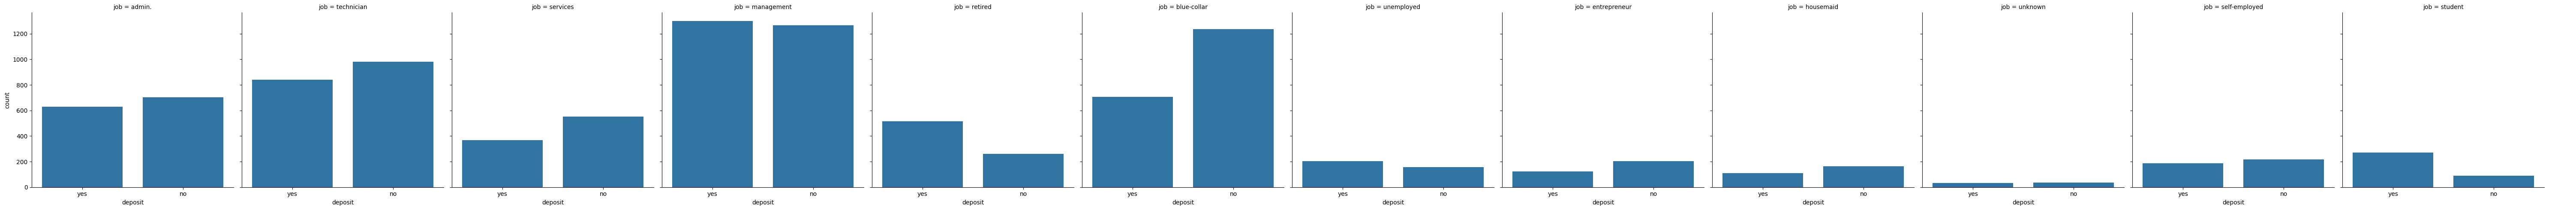

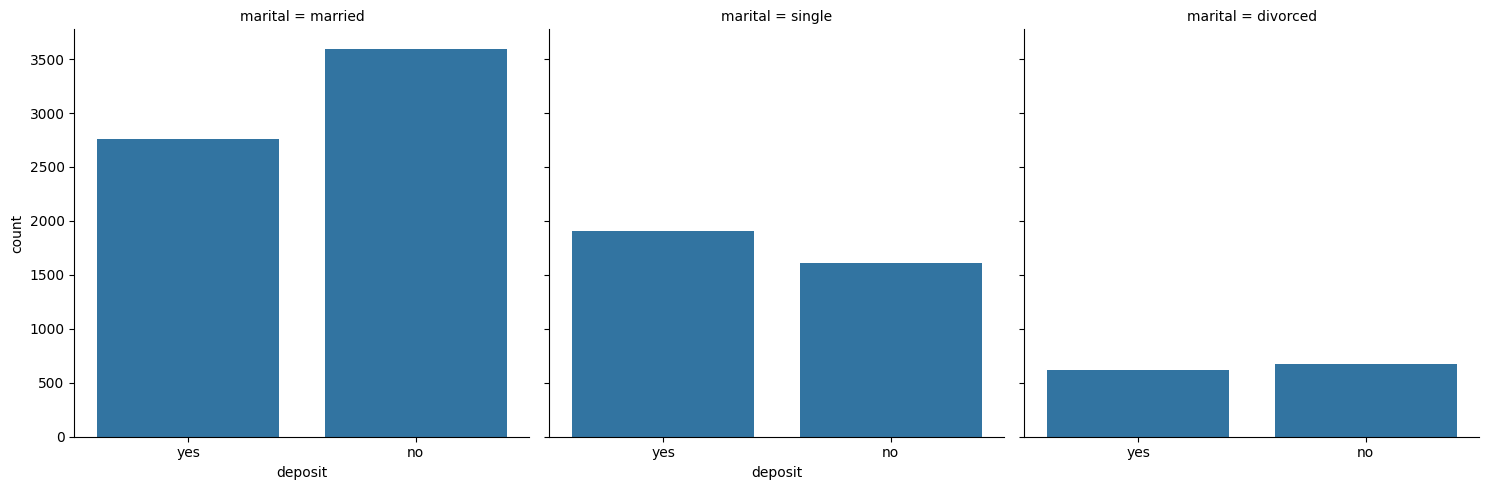

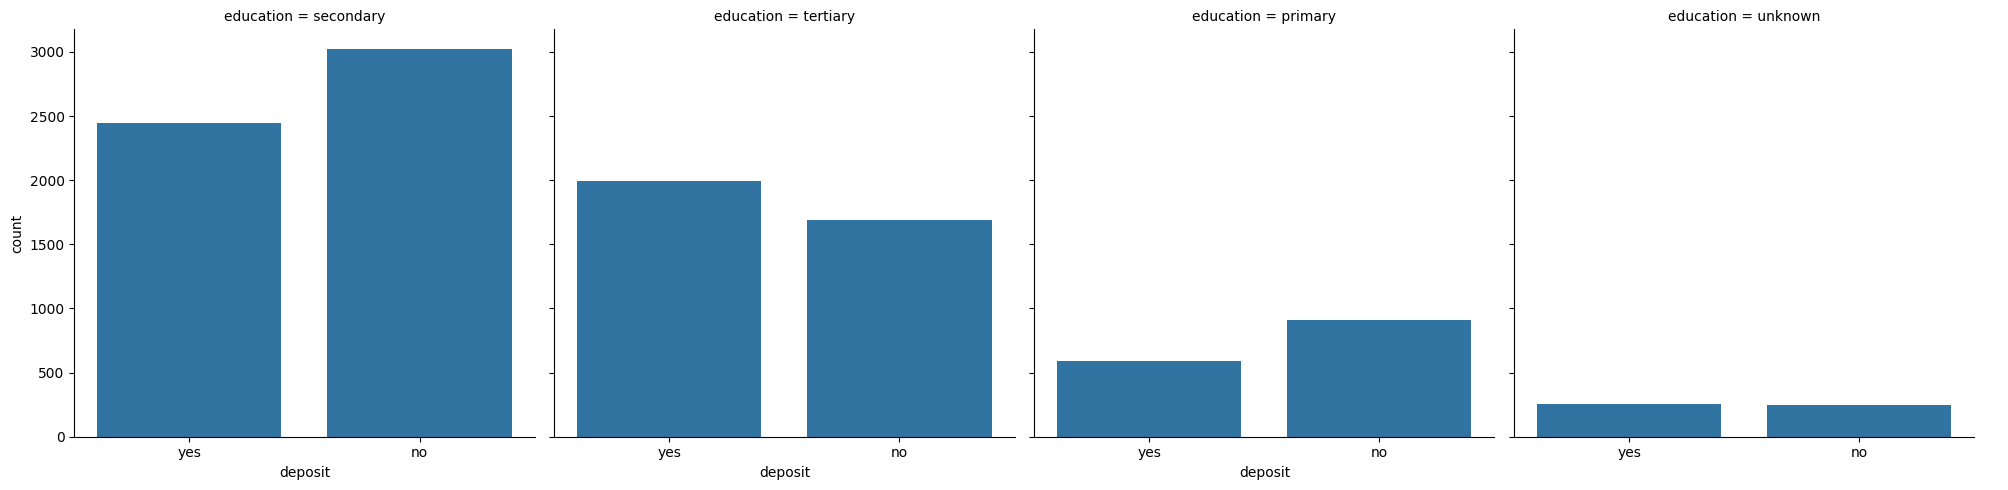

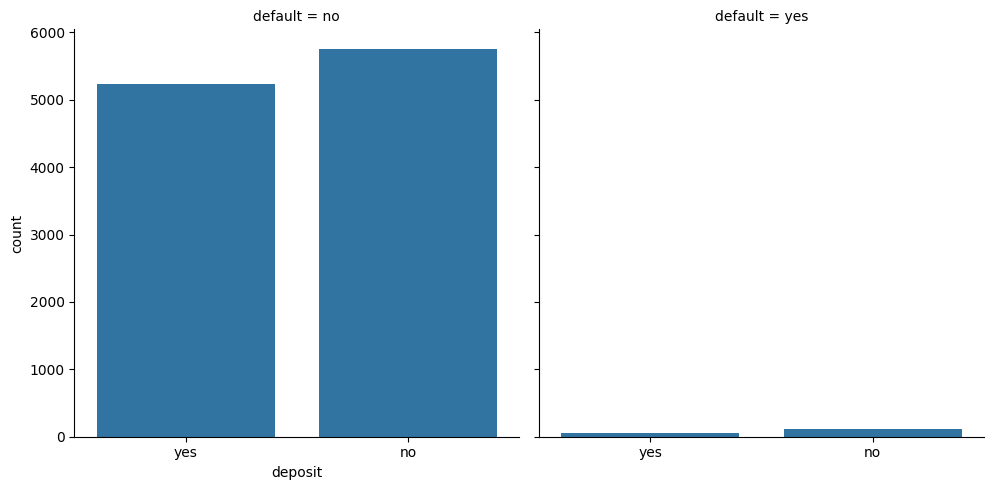

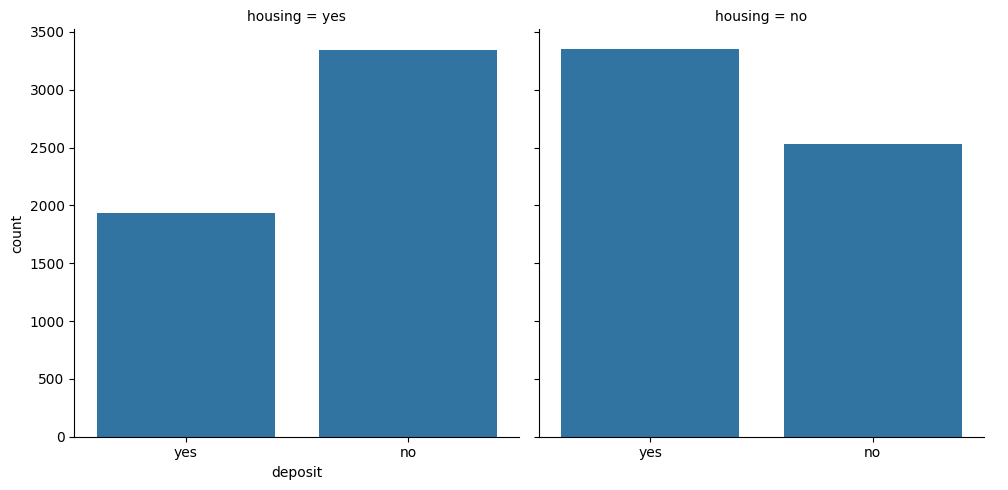

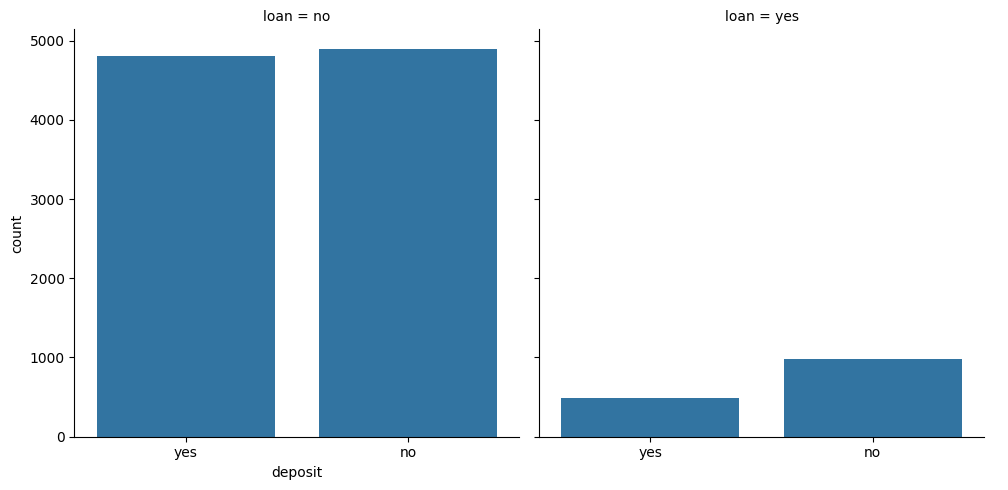

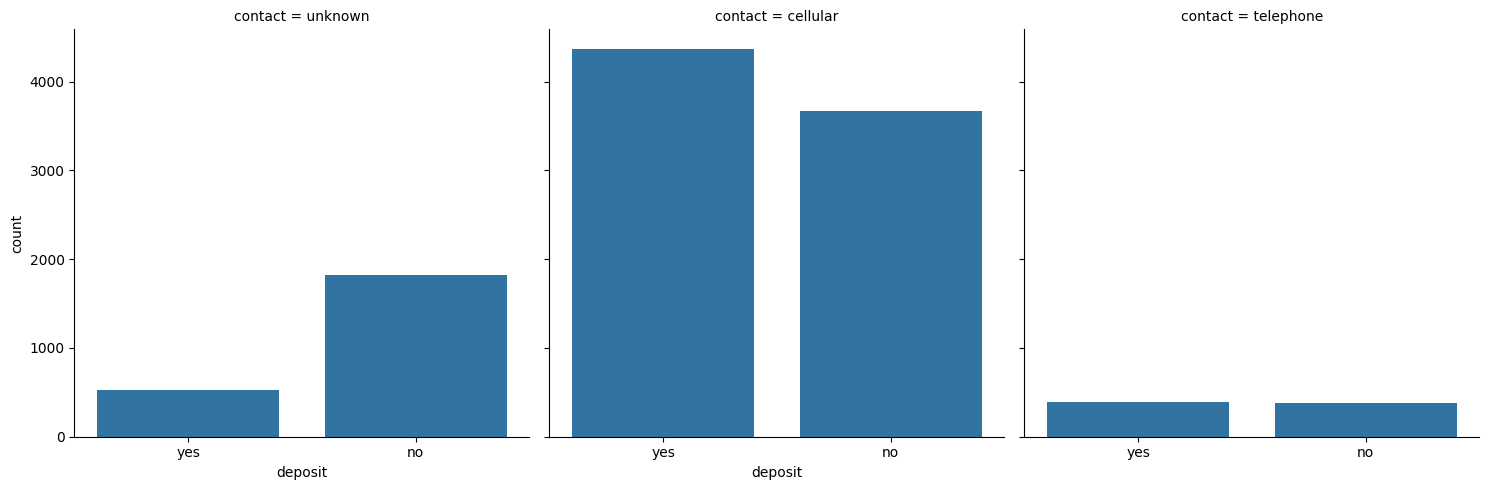

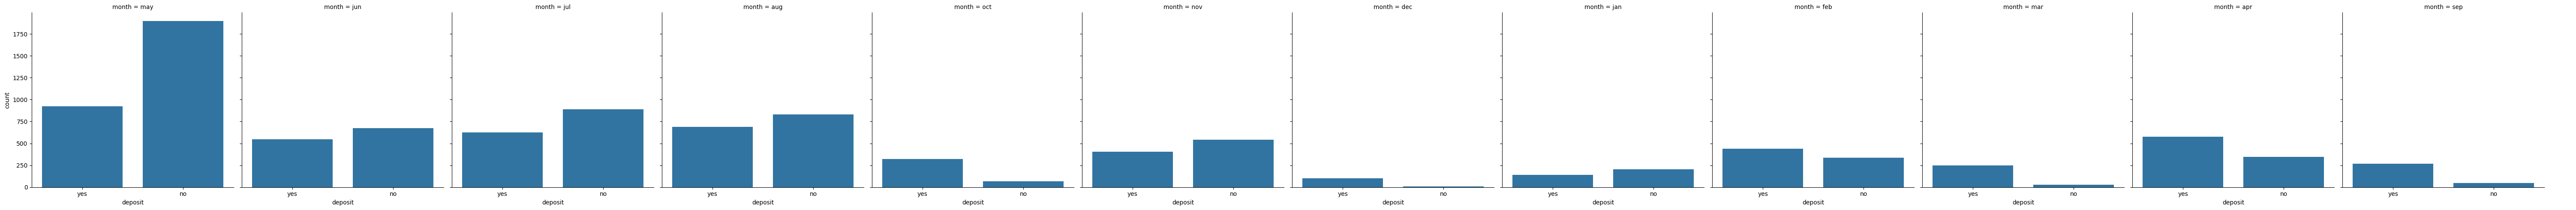

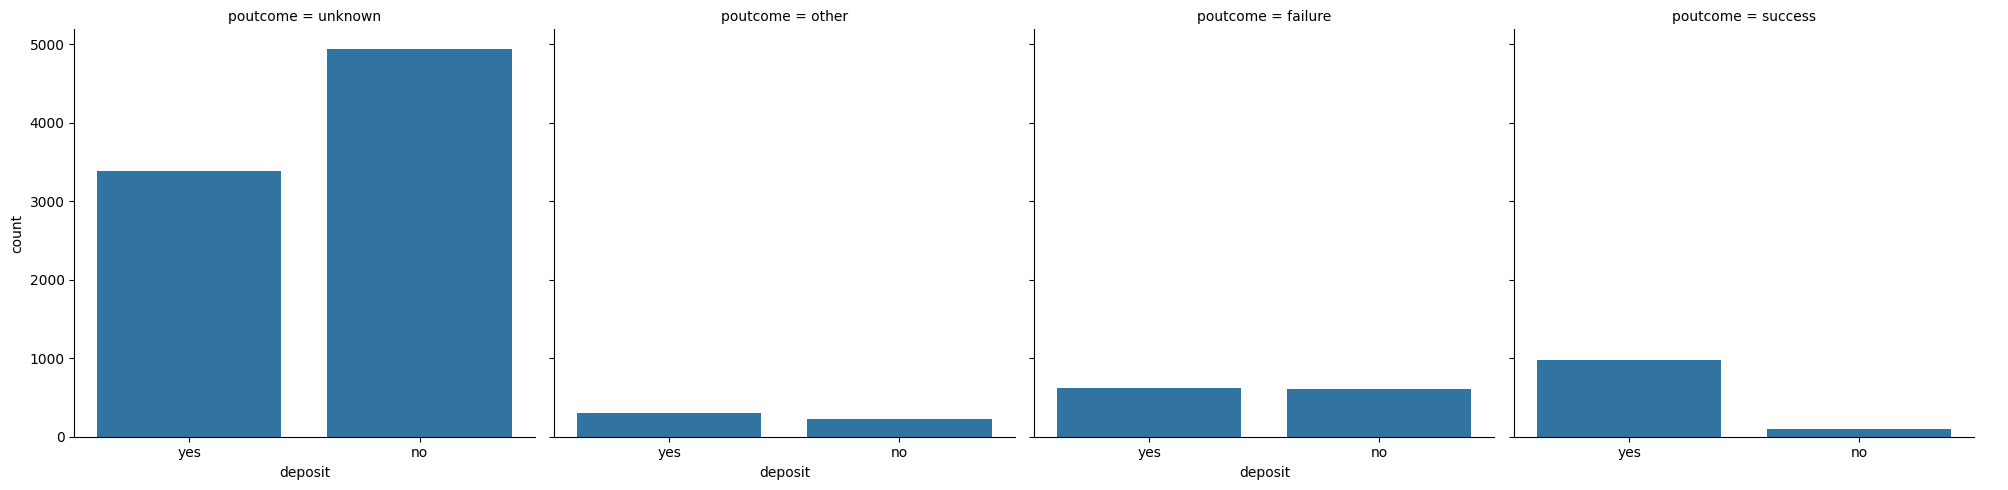

In [5]:
#check target label split over categorical features
#Find out the relationship between categorical variable and dependent variable
for categorical_feature in categorical_features:
    sns.catplot(x='deposit', col=categorical_feature, kind='count', data= df)
    plt.xlabel("")
    plt.ylabel("")
plt.show()

In [6]:
df.groupby(['deposit','default']).size()

deposit  default
no       no         5757
         yes         116
yes      no         5237
         yes          52
dtype: int64

In [7]:
# "default" no aporta informacio. Procedim a eliminar la columna
df.drop('default', axis=1, inplace=True)

In [8]:
df.groupby(['deposit','pdays']).size()
# "pdays" no aporta informacio. Procedim a eliminar la columna
df.drop('pdays', axis=1, inplace=True)

### EDA en Variables Numériques

In [9]:
deposit_={'yes':1,'no':0}
df['deposit']=df['deposit'].map(deposit_)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11162 non-null  float64
 1   job        11162 non-null  object 
 2   marital    11162 non-null  object 
 3   education  11162 non-null  object 
 4   balance    11162 non-null  int64  
 5   housing    11162 non-null  object 
 6   loan       11162 non-null  object 
 7   contact    11162 non-null  object 
 8   day        11162 non-null  int64  
 9   month      11162 non-null  object 
 10  duration   11162 non-null  int64  
 11  campaign   11162 non-null  int64  
 12  previous   11162 non-null  int64  
 13  poutcome   11162 non-null  object 
 14  deposit    11162 non-null  int64  
dtypes: float64(1), int64(6), object(8)
memory usage: 1.3+ MB


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,11162.0,41.226214,11.913532,18.0,32.0,39.0,49.0,95.0
balance,11162.0,1528.538524,3225.413326,-6847.0,122.0,550.0,1708.0,81204.0
day,11162.0,15.658036,8.420740,1.0,8.0,15.0,22.0,31.0
duration,11162.0,371.993818,347.128386,2.0,138.0,255.0,496.0,3881.0
campaign,11162.0,2.508421,2.722077,1.0,1.0,2.0,3.0,63.0
previous,11162.0,0.832557,2.292007,0.0,0.0,0.0,1.0,58.0
deposit,11162.0,0.473840,0.499338,0.0,0.0,0.0,1.0,1.0


In [11]:
correlation = df.corr(numeric_only=True)
correlation

,age,balance,day,duration,campaign,previous,deposit
age,1.000000,0.112173,-0.000485,0.000271,-0.005296,0.020264,0.034905
balance,0.112173,1.000000,0.010467,0.022436,-0.013894,0.030805,0.081129
day,-0.000485,0.010467,1.000000,-0.018511,0.137007,-0.058981,-0.056326
duration,0.000271,0.022436,-0.018511,1.000000,-0.041557,-0.026716,0.451919
campaign,-0.005296,-0.013894,0.137007,-0.041557,1.000000,-0.049699,-0.128081
previous,0.020264,0.030805,-0.058981,-0.026716,-0.049699,1.000000,0.139867
deposit,0.034905,0.081129,-0.056326,0.451919,-0.128081,0.139867,1.000000


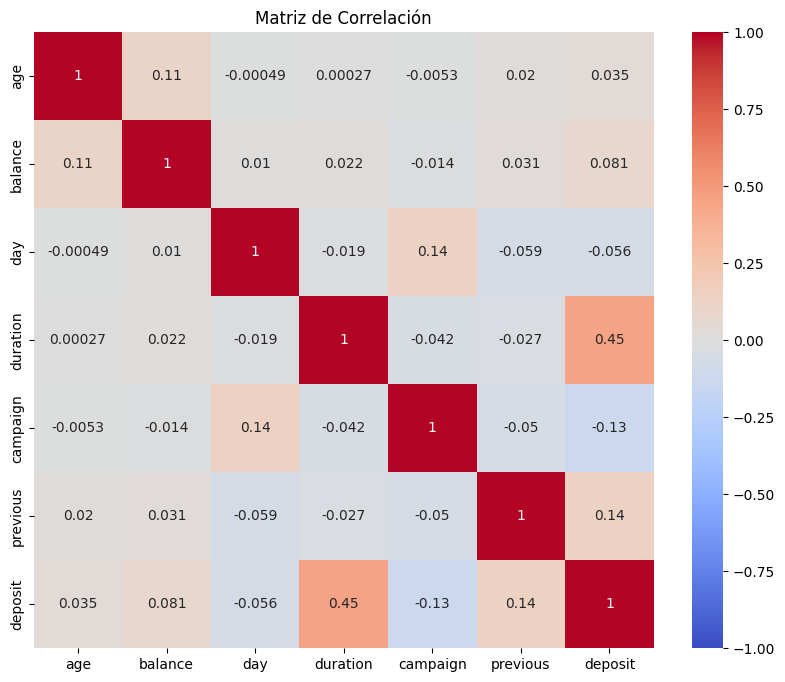

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlación')
plt.show()

In [13]:
df.deposit.value_counts() #Podem considerar de les dades estan balancejades

,count
deposit,
0,5873
1,5289


## Feature Engineering

### Reduir la dimensionalitat

In [14]:
#reduim la dimensionalitat en totes les variable categoriques

#reduim les dimensions de job
valors= df['job'].isin(['admin.', 'management'])
df.loc[valors, 'job'] = 'qualified'
valors= df['job'].isin(['blue-collar', 'services','technician'])
df.loc[valors, 'job'] = 'semi-q'
valors= df['job'].isin(['entrepreneur', 'housemaid','self-employed'])
df.loc[valors, 'job'] = 'freelance'
valors= df['job'].isin(['unemployed', 'unknown', 'retired', 'student'])
df.loc[valors, 'job'] = 'others'
df['job'] = df['job'].astype('category')

# “calificado,” “semicalificado,” “no calificado,” “freelance/autónomos,” y “otros” (incluyendo desempleados, retirados, estudiantes y “unknown”)

#reduim les dimensions de marital
df['marital']=df['marital'].astype('category')

#reduim les dimensions de education // mapeigem ordenant per nivells
education_={'unknown':0,'primary':1,'secondary':2,'tertiary':3}
df['education']=df['education'].map(education_)

housing_={'yes':1,'no':0}
df['housing']=df['housing'].map(housing_)

loan_={'yes':1,'no':0}
df['loan']=df['loan'].map(loan_)

month_={'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
df['month']=df['month'].map(month_)

#reduim les dimensions de contact
valor_others = df['contact'].isin(['unknown','telephone'])
df.loc[valor_others, 'contact'] = 'others'
df['contact']=df['contact'].astype('category')

#reduir les dimensions de poutcome
valor_others = df['poutcome'].isin(['unknown','other'])
df.loc[valor_others, 'poutcome'] = 'others'
df['poutcome']=df['poutcome'].astype('category')

df

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,deposit
0,59.0,qualified,married,2,2343,1,0,others,5,5,1042,1,0,others,1
1,56.0,qualified,married,2,45,0,0,others,5,5,1467,1,0,others,1
2,41.0,semi-q,married,2,1270,1,0,others,5,5,1389,1,0,others,1
3,55.0,semi-q,married,2,2476,1,0,others,5,5,579,1,0,others,1
4,54.0,qualified,married,3,184,0,0,others,5,5,673,2,0,others,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33.0,semi-q,single,1,1,1,0,cellular,20,4,257,1,0,others,0
11158,39.0,semi-q,married,2,733,0,0,others,16,6,83,4,0,others,0
11159,32.0,semi-q,single,2,29,0,0,cellular,19,8,156,2,0,others,0
11160,43.0,semi-q,married,2,0,0,1,cellular,8,5,9,2,5,failure,0


### Buscar i Eliminar Outliers

In [15]:
# remove outliers in feature balance...
df.groupby(['deposit','balance'],sort=True)['balance'].count()
# these outlier should not be remove as balance goes high, client show interest on deposit

deposit  balance
0        -6847      1
         -2712      1
         -2282      1
         -2049      1
         -1965      1
                   ..
1         34646     1
          36252     1
          45248     1
          52587     2
          81204     2
Name: balance, Length: 5082, dtype: int64

In [16]:
# remove outliers in feature duration...
df.groupby(['deposit','duration'],sort=True)['duration'].count()
# these outlier should not be remove as duration goes high, client show interest on deposit

deposit  duration
0        2           1
         3           1
         4           2
         5           4
         6           6
                    ..
1        3094        1
         3102        1
         3183        1
         3253        1
         3881        1
Name: duration, Length: 2157, dtype: int64

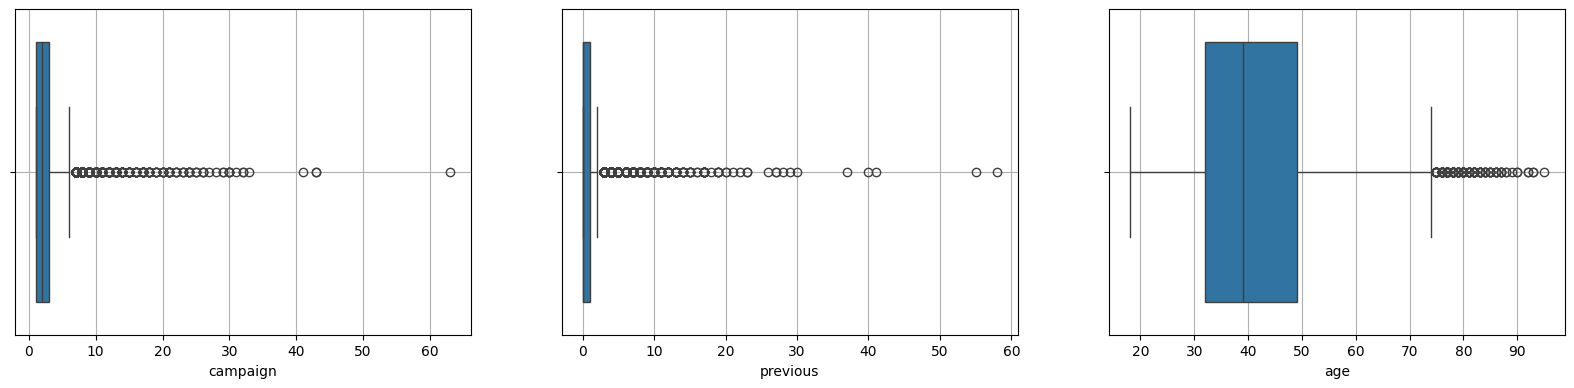

In [17]:
#Chech outliners

columns_to_check = ['campaign', 'previous', 'age']
# Crear diagramas de caja para visualizar outliers en cada columna
plt.figure(figsize=(20, 60))
plotnumber =1
for column in columns_to_check:
    ax = plt.subplot(12,3,plotnumber)
    sns.boxplot(x=df[column])
    plt.xlabel(column)
    plt.grid(True)
    plotnumber+=1
plt.show() # Se detectaron outliers en todas las columnas señaladas

In [18]:
# Para tratar los outliers se aplicará la técnica de Winsorización para mantener la estructura del dataset
# Función para calcular límites IQR
def calculate_iqr_limits(df, columns):
    limits_dict = {}

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        limits_dict[column] = (lower_bound, upper_bound)

    return limits_dict

In [19]:
# Función para winsorizar datos
def winsorize_data(df, columns):
    limits_dict = calculate_iqr_limits(df, columns)

    for column, (lower_bound, upper_bound) in limits_dict.items():
        # Winsorizar: Reemplazar valores menores que el límite inferior y mayores que el límite superior
        df[column] = np.clip(df[column], lower_bound, upper_bound)

    return df

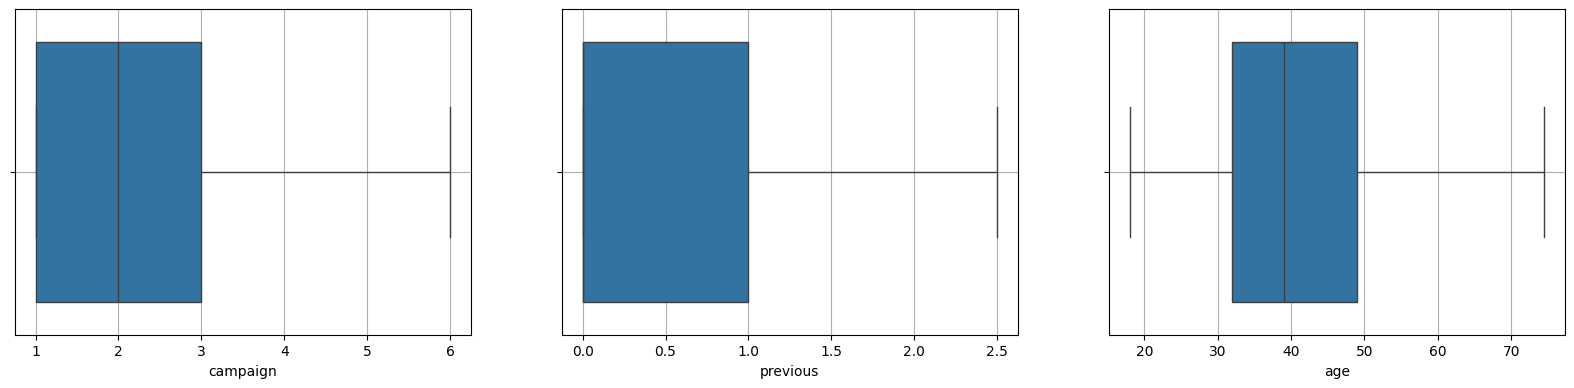

In [20]:
df = winsorize_data(df, columns_to_check)
plt.figure(figsize=(20, 60))
plotnumber =1
for column in columns_to_check:
    ax = plt.subplot(12,3,plotnumber)
    sns.boxplot(x=df[column])
    plt.xlabel(column)
    plt.grid(True)
    plotnumber+=1
plt.show() # Dades sense Outliers

**Comentari retroaccio entrega 6:**
Cuando las variables categóricas tienen múltiples categorías, se puede utilizar Label Encoding para evitar el aumento de dimensionalidad asociado con One-Hot Encoding.
Te sugiero que para la variable "educación", primero agrupes las categorías en niveles más generales (por ejemplo, "Básica", "Secundaria" y "Superior") y luego utilices Label Encoding, asignando números como 1, 2, 3, etc., a cada nivel educativo según su orden (de menor a mayor nivel). Esto se debe a que "educación" es una variable ordinal, donde el orden de las categorías tiene un significado. --> codifiquem "education" de 0-3

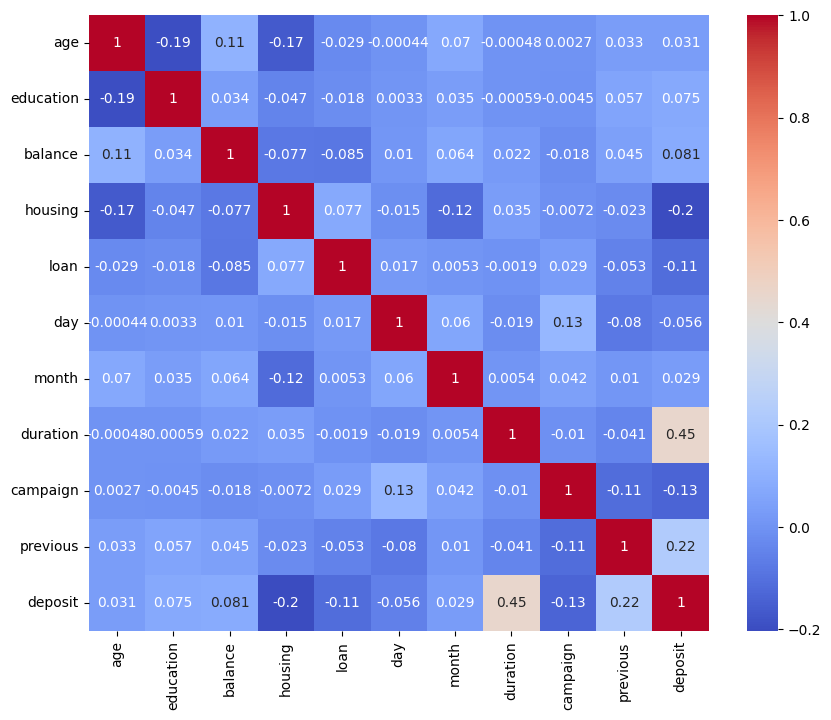

In [21]:

data_numeric = df.select_dtypes(include=['number'])
corr_matrix = data_numeric.corr()
# Mostrar la correlación entre características y la variable objetivo
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [22]:
# Codificacio Categorica One-Hot
from sklearn.preprocessing import OneHotEncoder

codificador = OneHotEncoder()
codificacion = codificador.fit_transform(df[['job', 'marital','contact','poutcome']])

new_columns = pd.DataFrame(codificacion.toarray(),
                    columns=codificador.get_feature_names_out())

combined_df = pd.concat([df, new_columns], axis=1)
df = combined_df.drop(['job', 'marital','contact','poutcome'], axis=1)
df.head()

,age,education,balance,housing,loan,day,month,duration,campaign,previous,...,job_qualified,job_semi-q,marital_divorced,marital_married,marital_single,contact_cellular,contact_others,poutcome_failure,poutcome_others,poutcome_success
0,59.0,2,2343,1,0,5,5,1042,1,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,56.0,2,45,0,0,5,5,1467,1,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,41.0,2,1270,1,0,5,5,1389,1,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,55.0,2,2476,1,0,5,5,579,1,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,54.0,3,184,0,0,5,5,673,2,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [23]:
print(df.columns)
print(df.shape)

Index(['age', 'education', 'balance', 'housing', 'loan', 'day', 'month',
       'duration', 'campaign', 'previous', 'deposit', 'job_freelance',
       'job_others', 'job_qualified', 'job_semi-q', 'marital_divorced',
       'marital_married', 'marital_single', 'contact_cellular',
       'contact_others', 'poutcome_failure', 'poutcome_others',
       'poutcome_success'],
      dtype='object')
(11162, 23)


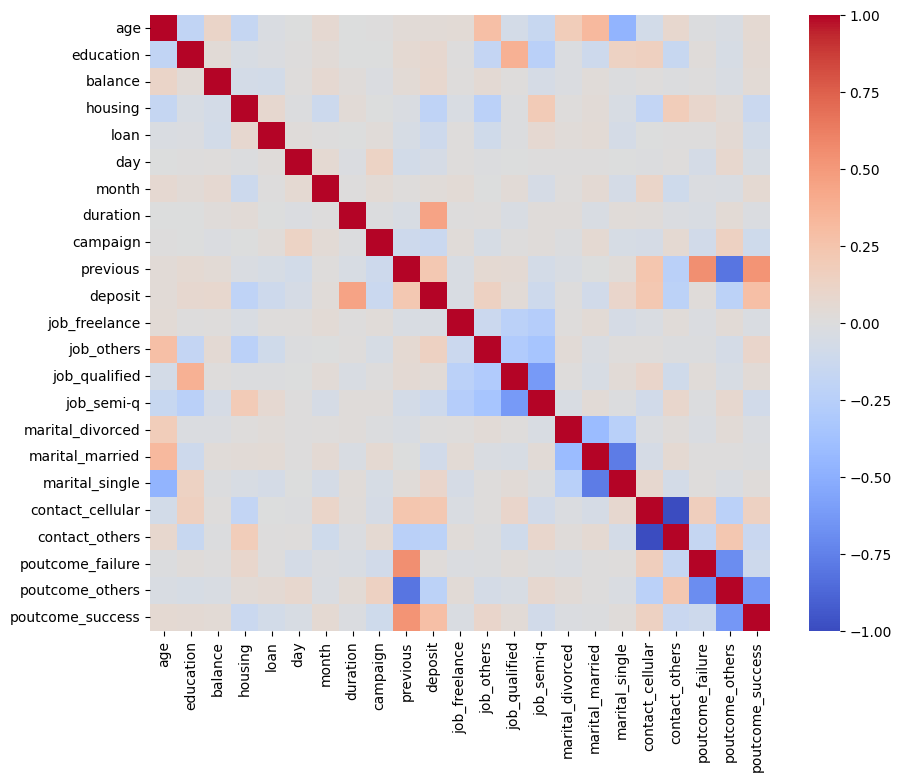

In [24]:
data_numeric = df.select_dtypes(include=['number'])
corr_matrix = data_numeric.corr()
# Mostrar la correlación entre características y la variable objetivo
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()


## Entrenar el model

### dividir les dades en conjunt de train i test

In [25]:
# Sel·leccionar subconjunts de dades d'entrenament i de prova
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

y=df['deposit']
X=df.loc[:, df.columns != 'deposit']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, # 70% assignat a entrenament + 30% assignat a test
                                                    random_state=0, # seleccionar dades aleatoriament
                                                    stratify=y) # mantenir la mateixa distribucio èxit/fracàs en ambdos conjunts

X.shape, X_train.shape, X_test.shape,y_train.shape, y_test.shape

((11162, 22), (7813, 22), (3349, 22), (7813,), (3349,))

### Escalar les dades i aplicar PCA si s'escau

**comentari retroaccio entrega 6:** solo debes escalar las caracteristica numéricas. Por otro lado, es importante el orden. Aplica el escalador y PCA después de dividir el conjunto de datos: ajusta en el conjunto de entrenamiento y transforma el conjunto de prueba.

**comentari retroaccio entrega 8.2:**
Observé que utilizaste scaler.fit_transform también en el conjunto de prueba. Esto no es correcto, ya que estarías ajustando el escalador nuevamente con los datos de prueba, lo que puede llevar a fuga de datos (data leakage).
En su lugar, recuerda que el escalador debe ajustarse solo con los datos de entrenamiento (scaler.fit), y luego aplicarse al conjunto de prueba utilizando scaler.transform.

In [26]:
# Escalem el conjunt de les dades X_train
scaler = StandardScaler()
columns_to_standarize = ['age','balance', 'day','duration', 'campaign', 'previous']
X_train[columns_to_standarize] = scaler.fit_transform(X_train[columns_to_standarize])
X_train.describe()


,age,education,balance,housing,loan,day,month,duration,campaign,previous,...,job_qualified,job_semi-q,marital_divorced,marital_married,marital_single,contact_cellular,contact_others,poutcome_failure,poutcome_others,poutcome_success
count,7.813000e+03,7813.000000,7.813000e+03,7813.000000,7813.000000,7.813000e+03,7813.000000,7.813000e+03,7.813000e+03,7.813000e+03,...,7813.000000,7813.000000,7813.000000,7813.000000,7813.000000,7813.000000,7813.000000,7813.000000,7813.000000,7813.000000
mean,1.409627e-16,2.104825,-2.000760e-17,0.475362,0.132983,1.818873e-17,6.217842,5.729450e-17,-5.456619e-17,6.729830e-17,...,0.349546,0.416613,0.114681,0.574043,0.311276,0.717650,0.282350,0.111737,0.790861,0.097402
std,1.000064e+00,0.797554,1.000064e+00,0.499425,0.339579,1.000064e+00,2.574473,1.000064e+00,1.000064e+00,1.000064e+00,...,0.476857,0.493029,0.318657,0.494519,0.463045,0.450172,0.450172,0.315063,0.406720,0.296523
min,-1.990084e+00,0.000000,-1.427286e+00,0.000000,0.000000,-1.743163e+00,1.000000,-1.064218e+00,-8.142850e-01,-5.422364e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.858588e-01,2.000000,-4.367239e-01,0.000000,0.000000,-9.125930e-01,5.000000,-6.741412e-01,-8.142850e-01,-5.422364e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,-1.837461e-01,2.000000,-3.030246e-01,0.000000,0.000000,-8.202281e-02,6.000000,-3.385602e-01,-1.606316e-01,-5.422364e-01,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,6.764148e-01,3.000000,5.715136e-02,1.000000,0.000000,7.485474e-01,8.000000,3.584159e-01,4.930218e-01,5.794191e-01,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,2.869825e+00,3.000000,2.489461e+01,1.000000,1.000000,1.816423e+00,12.000000,1.006159e+01,2.453982e+00,2.261902e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


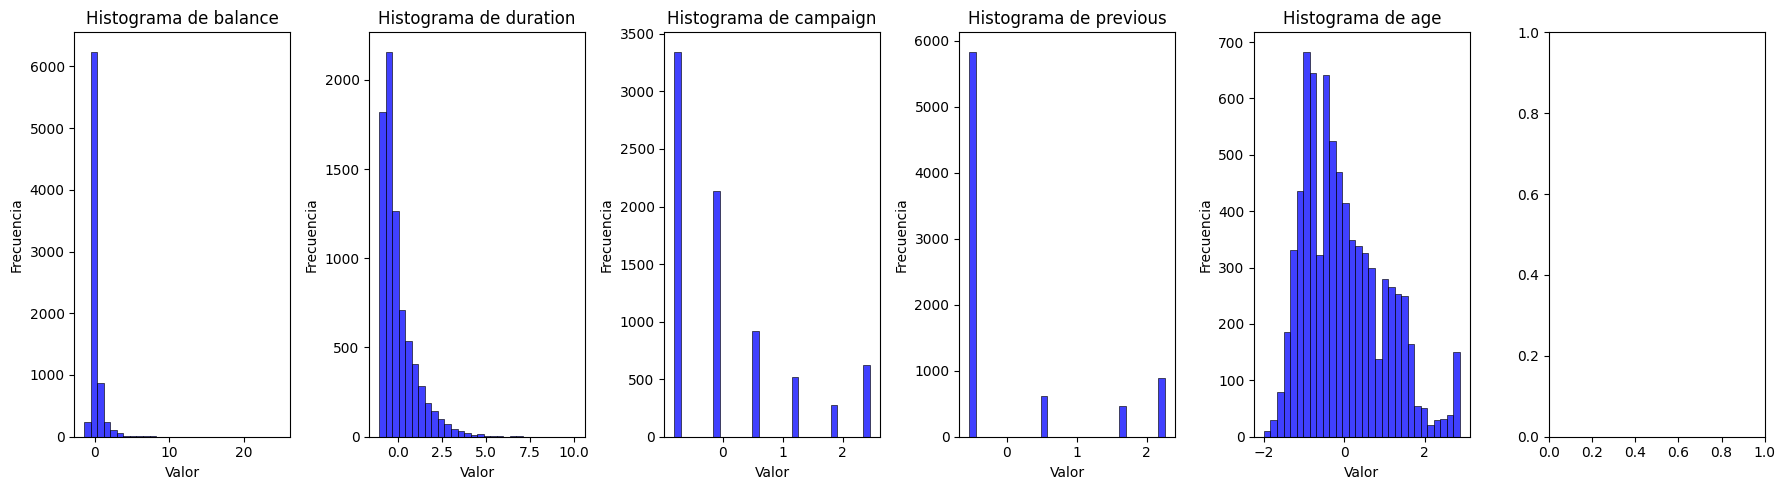

In [27]:
#Chequear el resultado con histogramas para ver media 0 y desvío estándar=1
# Crear una figura con subgráficos para cada columna numérica
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(18, 5))
# Definir las columnas para visualizar
columns_to_plot = ['balance', 'duration', 'campaign', 'previous', 'age']
# Iterar sobre cada columna para crear un histograma
for i, column in enumerate(columns_to_plot):
    sns.histplot(X_train[column], kde=False, ax=axes[i], color='blue', bins=30)
    axes[i].set_title(f'Histograma de {column}')
    axes[i].set_xlabel('Valor')
    axes[i].set_ylabel('Frecuencia')
# Ajustar el diseño
plt.tight_layout()
plt.show()


In [28]:
# No apliquem PCA al conjunt de entrenament per no perdre interpretabilitat
# pca = PCA(n_components=0.90)
# X_train = pca.fit_transform(X_train)
# X_train.shape

In [29]:
# Escalem el conjunt de les dades X_test
#scaler = StandardScaler()
#columns_to_standarize = ['age','balance', 'day','duration', 'campaign', 'previous']
X_test[columns_to_standarize] = scaler.transform(X_test[columns_to_standarize])
X_test.describe()

,age,education,balance,housing,loan,day,month,duration,campaign,previous,...,job_qualified,job_semi-q,marital_divorced,marital_married,marital_single,contact_cellular,contact_others,poutcome_failure,poutcome_others,poutcome_success
count,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,...,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000
mean,0.002990,2.107495,0.018212,0.467901,0.125709,-0.013148,6.127799,-0.009988,-0.015614,0.007371,...,0.349059,0.428486,0.117946,0.558077,0.323977,0.727083,0.272917,0.106002,0.801433,0.092565
std,1.009573,0.792607,1.024871,0.499043,0.331571,0.997086,2.568145,0.985350,0.980816,1.003804,...,0.476744,0.494933,0.322592,0.496690,0.468061,0.445525,0.445525,0.307886,0.398981,0.289865
min,-1.990084,0.000000,-2.610900,0.000000,0.000000,-1.743163,1.000000,-1.052746,-0.814285,-0.542236,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.785859,2.000000,-0.427977,0.000000,0.000000,-0.912593,5.000000,-0.671273,-0.814285,-0.542236,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,-0.183746,2.000000,-0.296152,0.000000,0.000000,-0.082023,6.000000,-0.344297,-0.160632,-0.542236,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,0.676415,3.000000,0.069959,1.000000,0.000000,0.629895,8.000000,0.335470,0.493022,0.579419,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,2.869825,3.000000,20.349147,1.000000,1.000000,1.816423,12.000000,8.349261,2.453982,2.261902,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
# NO Apliquem PCA al conjunt de test
#pca = PCA(n_components=0.90)
# X_test = pca.fit_transform(X_test)
# X_test.shape

### Entrenar el model de regressio lineal

In [31]:
## ENTRENAR EL MODELO
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Crear el modelo de regresión lineal
model = LogisticRegression()

model_score =cross_val_score(model,X_train,y_train, cv=5)
print(model_score)
print(model_score.mean())

[0.79910429 0.78566859 0.7971849  0.82714469 0.80921895]
0.8036642819752225


una valoracio de matriu creuada amb valors de 80% o superior indica que el model funciona correctament.

In [37]:
# Entrenar el modelo con los datos de entrenamiento completo
model.fit(X_train, y_train)

# Hacer predicciones con el conjunto de prueba
y_pred = model.predict(X_test)



In [41]:
def metricas(clases_reales, clases_predichas):
    """ Calcular las métricas utilizando sklearn """
    matriz = confusion_matrix(clases_reales, clases_predichas)
    accuracy = accuracy_score(clases_reales, clases_predichas)
    precision = precision_score(clases_reales, clases_predichas)
    recall = recall_score(clases_reales, clases_predichas)
    f1 = f1_score(clases_reales, clases_predichas)
    auc = roc_auc_score(clases_reales, clases_predichas)
    return matriz, accuracy, precision, recall, f1, auc

def visualiza_metricas(clases_reales, clases_predichas, titulo):
    """ Visualiza la matriz de confusión y métricas """

    #Código para calcular las métricas y matriz de confusión

    matriz, accuracy, precision, recall, f1, auc = \
                    metricas(clases_reales, clases_predichas)

    #Código de matplotlib para graficar
    plt.figure(figsize=(3, 3))
    matriz = pd.DataFrame(matriz,
                          columns=["0 : No Deposit", "1 : Deposit"])
    plt.matshow(matriz, cmap="Blues", vmin=0, vmax=10, fignum=1)
    plt.title("Reales")
    plt.ylabel("Predichas")
    plt.xticks(range(len(matriz.columns)), matriz.columns, rotation=45)
    plt.yticks(range(len(matriz.columns)), matriz.columns)
    etiquetas = (("Verdaderos\nnegativos", "Falsos\npositivos"),
                 ("Falsos\nnegativos", "Verdaderos\npositivos"))
    for i in range(len(matriz.columns)):
        for j in range(len(matriz.columns)):
            plt.text(i, j + 0.14, str(matriz.iloc[i, j]),
                     fontsize=30, ha="center", va="center")
            plt.text(i, j - 0.25, etiquetas[i][j],
                     fontsize=11.5, ha="center", va="center")
    plt.text(1.60, -0.30, titulo, fontsize=25, c="red")
    plt.text(2.1, 0.10, "Accuracy: %0.2f" % accuracy, fontsize=20)
    plt.text(2.1, 0.40, "Precision: %0.2f" % precision, fontsize=20)
    plt.text(2.1, 0.70, "Recall: %0.2f" % recall, fontsize=20)
    plt.text(2.1, 1.00, "F1: %0.2f" % f1, fontsize=20)
    plt.text(2.1, 1.30, "AUC: %0.2f" % auc, fontsize=20)
    plt.show()

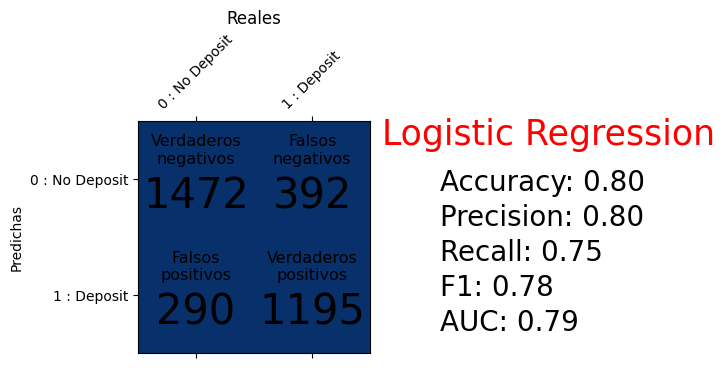

In [42]:
clases_reales = y_test
clases_predichas = y_pred

titulo = "Logistic Regression"
visualiza_metricas(clases_reales, clases_predichas, titulo)

Un algoritme de regresio logistica ens esta donant una precisio de 80%, on encerta 1472 casos que no subscriuen el deposit i 1195 casos que si el subscriuen. D'altra banda falla en la prediccio de 392 casos on prediu que no subscriuen el diposit i si ho fan, i en 290 casos a l'inversa.

### Comparem els resultats amb d'altres algoritmes de classificacio: RandomForest


In [43]:
from sklearn.ensemble import RandomForestClassifier

bosque = RandomForestClassifier()
bosque_score =cross_val_score(bosque,X_train, y_train, cv=5)
print(bosque_score)
print(bosque_score.mean())

[0.83301344 0.83621241 0.84836852 0.85659411 0.83994878]
0.8428274527055312


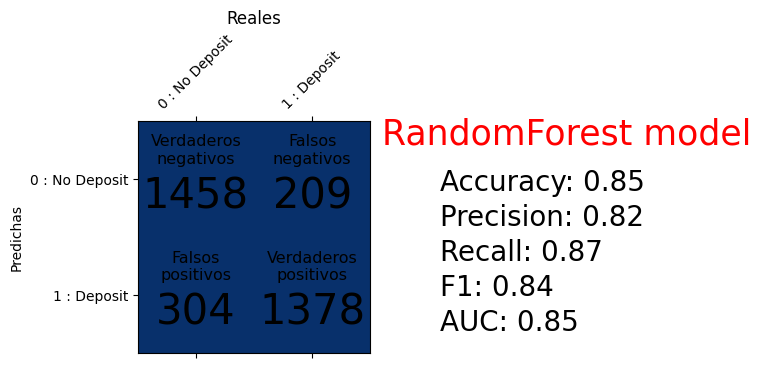

In [44]:
# Entrenar el modelo con los datos de entrenamiento completo
bosque.fit(X_train, y_train)

# Hacer predicciones con el conjunto de prueba
y_pred = bosque.predict(X_test)

clases_reales = y_test
clases_predichas = y_pred

titulo = "RandomForest model"
visualiza_metricas(clases_reales, clases_predichas, titulo)

# EL MODEL RANDOM FOREST AJUSTA MILLOR LA PREDICCIO DE LES DADES

Amb la eleccio d'un model Random Forest millorem el resultat de precisio d'encert fins al 85%

### Provem d'ajustar RandomForest amb alguns hiperparametres ##




In [ ]:
bosque.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

parametros = {
    'max_features': ['sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}

rejilla= GridSearchCV(estimator=bosque, param_grid=parametros, cv= 5)
rejilla.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2']})

In [ ]:
print(rejilla.cv_results_["rank_test_score"])
print(rejilla.cv_results_["mean_test_score"])
print(rejilla.best_score_)
print(rejilla.best_params_)

[3 2 1 4]
[0.84359529 0.84449149 0.84513096 0.84308386]
0.8451309614214104
{'criterion': 'entropy', 'max_features': 'sqrt'}


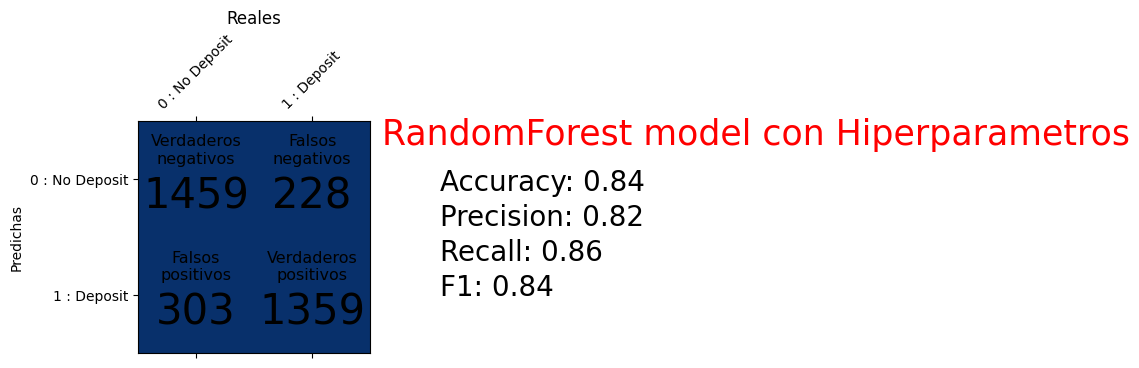

In [ ]:
new_model = RandomForestClassifier(criterion='gini', max_features='sqrt')
new_model.fit(X_train, y_train)
y_pred = new_model.predict(X_test)
clases_reales = y_test
clases_predichas = y_pred

titulo = "RandomForest model con Hiperparametros"
visualiza_metricas(clases_reales, clases_predichas, titulo)

In [ ]:
parametros = {
    'n_estimators': [100,200,300],
    'max_features': ['sqrt'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini']
}

rejilla_aleatorio= RandomizedSearchCV(bosque, parametros, scoring="accuracy", cv= 5, n_iter=3)
rejilla_aleatorio.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=3,
                   param_distributions={'criterion': ['gini'],
                                        'max_depth': [4, 5, 6, 7, 8],
                                        'max_features': ['sqrt'],
                                        'n_estimators': [100, 200, 300]},
                   scoring='accuracy')

In [ ]:
print(rejilla_aleatorio.best_score_)
print(rejilla_aleatorio.best_params_)

0.833868516748136
{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'gini'}


## Conclusions:

- Hem verificat que les dades estaven balancejades
- Hem aplicat fet tractament dels valors nuls
- Hem fet tractament dels valors outliers amb winsoritzacio
- Hem aplicat Label Encoding o OneHotEncoding segons cada categoria
- Hem separat el DataSet en un conjunt d'entrenament 70% i test 30%
- Hem aplicat per separat escalat i sense PCA
- Hem comprovat com es comportaria l'algoritme de Regressio Logistica
- Hem comprovat com es comportaria l'algoritme de Random Forest
- Hem provat de modificat algun hiperparametre en forma de "rejilla" i "rejilla" aleatoria
- EL MILLOR RESULTAT OBTINGUT TE UNA PRECISSIÓ DEL 85%
- El perfil tipus del contractant d'un diposit es una persona amb elevats ingresos, estudis terciaris, sense hipoteca, i que aguanti el maxim de temps al telefon.

## Guardar el model i el escalador


In [ ]:
import pickle
# Guardar el modelo
with open('linear_model.pkl', 'wb') as model_file:
    pickle.dump(bosque, model_file)

# Guardar el escalador
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)